# Project4 : Stackworkflow Survey Results


### Import necessary libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

### Load the data

In [2]:
# Load in the Stackoverflow survey results.
survey_results = pd.read_csv('survey_results_public.csv')

# Load in the survey questions file.
feat_info = pd.read_csv('survey_results_schema.csv')

In [3]:
#data dimensions
n_rows,n_cols = survey_results.shape
print("Total number of participants: {} for {} questions".format(n_rows,n_cols))

Total number of participants: 51392 for 154 questions


In [4]:
#take a look at how the data look like
survey_results.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def plot_percentages(stat):
    if stat.shape[0] > 10:
        plt.barh(stat.iloc[0:9, 0], stat.iloc[0:9, 2])
    else:
        plt.barh(stat.iloc[:, 0], stat.iloc[:, 2])
        


# a function to view for a given feature, the count and percentage of each value 
# the feature here should be a question where multiple selection is not allowed
def feature_stat_single(feature_name, df):
    feature_value_counts = df[feature_name].value_counts().reset_index()
    feature_value_counts.rename(columns={'index': feature_name, feature_name: 'count'}, inplace=True)
    feature_value_counts['percentage'] = feature_value_counts['count']/np.sum(feature_value_counts['count']) * 100
    plot_percentages(feature_value_counts)
    display(feature_value_counts)
    return feature_value_counts
 
# a function to view for a given feature, the count and percentage of each value 
# the feature here should be a question where multiple selection is allowed
def feature_stats_multiple(feature_name, df):
    n_participants = df.shape[0]
    df[feature_name] = df[feature_name].str.split('; ')
    all_values = np.hstack(df[feature_name])
    #remove missing values as the propotion of the missing values differes among different sub-groups like students/professionals
    #so this difference will mess up the comparison between them
    all_values = all_values[~(all_values=='nan')]
    all_values = pd.Series(all_values).value_counts().reset_index()
    all_values.rename(columns={'index': feature_name, 0: 'count'}, inplace=True)
    all_values['percentage'] = all_values['count']/n_participants * 100
    plot_percentages(all_values)
    display(all_values)
    return all_values


pd.options.mode.chained_assignment = None

### There are many quesions I'm interested in how the Sack Overflow data would answer:
### Q1: Are the languages used  in industry by professional developers being taught in universities? In other words: Do universities teach students useful materials to prepare them for their future careers as developers?

,Professional,count,percentage
0,Professional developer,36131,70.304717
1,Student,8224,16.002491
2,Professional non-developer who sometimes write...,5140,10.001557
3,Used to be a professional developer,983,1.912749
4,None of these,914,1.778487


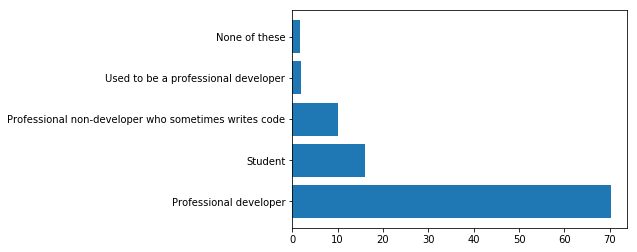

In [6]:
#let's start by investigating the distribution of the participants' profession
profession_stat = feature_stat_single('Professional', survey_results)

In [7]:
#although we have much fewer students than professional developers, the number of students is high enough to answer the question
#so now I will create two dataframes, one for students, and the other of professional developers

professional=survey_results[survey_results['Professional']=='Professional developer']
students=survey_results[survey_results['Professional']=='Student']

,EmploymentStatus,count,percentage
0,"Not employed, and not looking for work",2310,28.088521
1,"Not employed, but looking for work",1919,23.334144
2,Employed full-time,1264,15.369650
3,Employed part-time,1255,15.260214
4,"Independent contractor, freelancer, or self-em...",747,9.083171
5,I prefer not to say,704,8.560311
6,Retired,25,0.303988


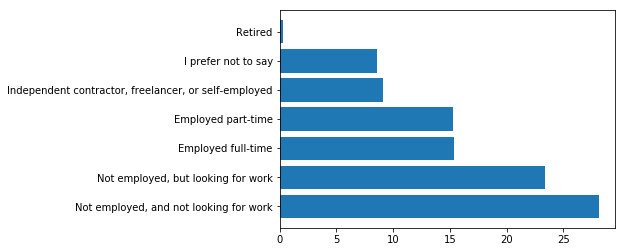

In [8]:
#now let's check the employment status of students to make sure that we take into account employed students
stud_emp = feature_stat_single('EmploymentStatus', students)

In [9]:
#as seen above, almost have of the students are either working for a company or independently so it would be interesting to 
#make a languages-comparison between employed students and not employed students
stud_not_employed= students[students['EmploymentStatus'].isin(['Not employed, and not looking for work','Not employed, but looking for work'])]
stud_employed= students[students['EmploymentStatus'].isin(['Employed full-time','Employed part-time', 'Independent contractor, freelancer, or self-employed'])]


,HaveWorkedLanguage,count,percentage
0,Java,1325,31.331284
1,Python,1130,26.720265
2,JavaScript,1120,26.483802
3,C++,1024,24.213762
4,C,977,23.102388
5,SQL,847,20.028376
6,PHP,690,16.315914
7,C#,598,14.140459
8,Assembly,279,6.597304
9,Matlab,182,4.303618


,HaveWorkedLanguage,count,percentage
0,Java,1325,31.331284
1,Python,1130,26.720265
2,JavaScript,1120,26.483802
3,C++,1024,24.213762
4,C,977,23.102388
5,SQL,847,20.028376
6,PHP,690,16.315914
7,C#,598,14.140459
8,Assembly,279,6.597304
9,Matlab,182,4.303618


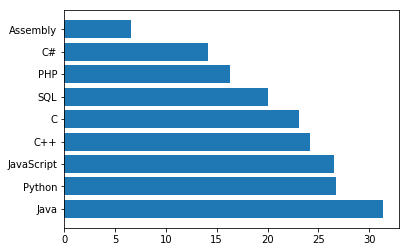

In [10]:
feature_stats_multiple('HaveWorkedLanguage', stud_not_employed)

,HaveWorkedLanguage,count,percentage
0,Java,1084,33.190447
1,JavaScript,1082,33.129210
2,SQL,866,26.515615
3,Python,801,24.525413
4,C++,687,21.034905
5,PHP,661,20.238824
6,C,633,19.381506
7,C#,595,18.218004
8,Assembly,217,6.644213
9,Matlab,167,5.113288


,HaveWorkedLanguage,count,percentage
0,Java,1084,33.190447
1,JavaScript,1082,33.129210
2,SQL,866,26.515615
3,Python,801,24.525413
4,C++,687,21.034905
5,PHP,661,20.238824
6,C,633,19.381506
7,C#,595,18.218004
8,Assembly,217,6.644213
9,Matlab,167,5.113288


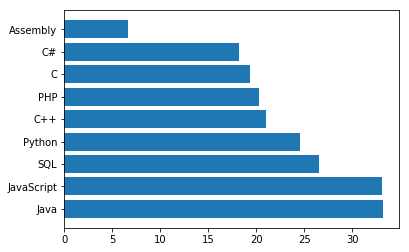

In [11]:
#note that the percentages won't add up to 100 as each participant was allowed to choose multiple languages
feature_stats_multiple('HaveWorkedLanguage', stud_employed)

comparing the languages used by employed students and un-employed students: 
- the most common language used is the same at both of them: Java. I was expecting this result as universities tend to use Java to teach object-oriented programming to students.
- there is a clear difference in the percentages of using Javascript and SQL. These two languages are more popular ampong employed students as they are widely used in indstry. SQL is needed to interact with database and it's really hard to find a company without a database. On the other hand, most un-employed students would not necessarily have access to a database. Javascript is an essential language for web development which is mostly what you will end up doing at somepoint as a professional developer in the industry and even elementary schools need websites nowadays.


,EmploymentStatus,count,percentage
0,Employed full-time,30211,83.615178
1,"Independent contractor, freelancer, or self-em...",3691,10.215604
2,Employed part-time,1424,3.941214
3,"Not employed, but looking for work",465,1.286983
4,I prefer not to say,192,0.531400
5,"Not employed, and not looking for work",123,0.340428
6,Retired,25,0.069193


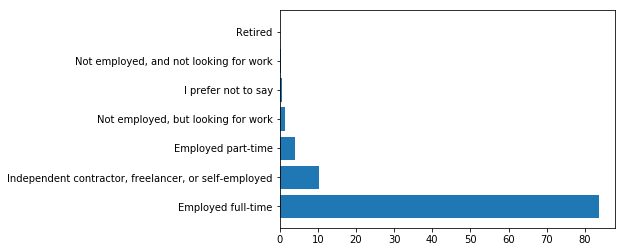

In [12]:
#I want to check out the employment status of professional developers to remove the unemployed ones jsut to make sure they 
#won't affect the comparsion
prof_emp = feature_stat_single('EmploymentStatus', professional)

In [13]:
#as seen above, most of professional are employed, I will keep the first three highest values and remove the rest
prof_employed= professional[professional['EmploymentStatus'].isin(['Employed full-time','Employed part-time', 'Independent contractor, freelancer, or self-employed'])]

,HaveWorkedLanguage,count,percentage
0,JavaScript,18071,51.154957
1,SQL,14574,41.255732
2,Java,10362,29.332503
3,C#,9963,28.203023
4,Python,7424,21.015683
5,PHP,7347,20.797713
6,C++,5149,14.575667
7,C,4109,11.631659
8,TypeScript,3066,8.679160
9,Ruby,2548,7.212818


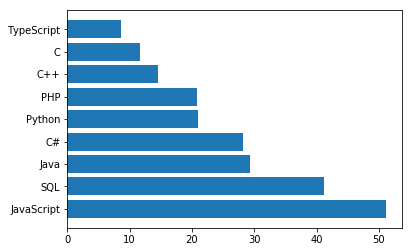

In [14]:
feature_stats_multiple('HaveWorkedLanguage', prof_employed);

comparing the languages used by employed professional developers and un-employed students: 
- the number of different languages used in both groups is the same but the percentage of the language usage differes.
- the differences I mentioned in the earlier comparison above can be seen even clearer here: Javascript and SQL is used 20% more by developers in industry than it's used among univirsity students. I personally think we should pay more attention to these languages as they're more likely to be required in students' future careers.

### Q2: I heard in many occasions people saying that it's better to work in a small company as it makes you feel more included and it allows you to handle important projects all by yourself and see the results of your work directly in front of your eyes which is something you won't necessarily get when working for a big company. I also heard other people saying that it's more secure to work in big companies because of their resources. Can this dataset prove any of these rumors?

,CompanySize,count,percentage
0,20 to 99 employees,8587,22.062073
1,100 to 499 employees,7274,18.688659
2,"10,000 or more employees",5680,14.593289
3,10 to 19 employees,4103,10.541596
4,"1,000 to 4,999 employees",3831,9.842762
5,Fewer than 10 employees,3807,9.781101
6,500 to 999 employees,2486,6.387133
7,"5,000 to 9,999 employees",1604,4.121063
8,I don't know,869,2.232670
9,I prefer not to answer,681,1.749653


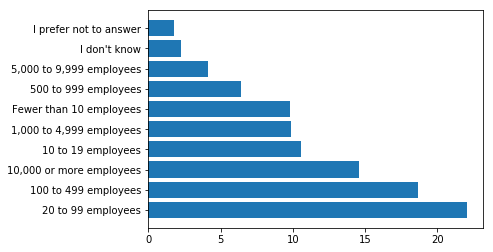

In [15]:
#to start answering this question, let's explore the the company size column
feature_stat_single('CompanySize', survey_results);

In [16]:
# from the above distribution, it seems like we have a wide variety of sizes in the data
# the main focus here is to see the impact of the company size on job satisfaction and salary
# hence, I will check the availability of the data in the target columns and view the distribution again
print('number of missing values in Salary column: {}'.format(survey_results['Salary'].isna().sum()))
display(survey_results[(pd.isnull(survey_results['Salary']))].EmploymentStatus.unique())
print('number of missing values in Career Satisfaction column: {}'.format(survey_results['CareerSatisfaction'].isna().sum()))
print('number of missing values in Job Satisfaction column: {}'.format(survey_results['JobSatisfaction'].isna().sum()))

number of missing values in Salary column: 38501


array(['Not employed, and not looking for work', 'Employed part-time',
       'Employed full-time',
       'Independent contractor, freelancer, or self-employed',
       'Not employed, but looking for work', 'I prefer not to say',
       'Retired'], dtype=object)

number of missing values in Career Satisfaction column: 8697
number of missing values in Job Satisfaction column: 11016


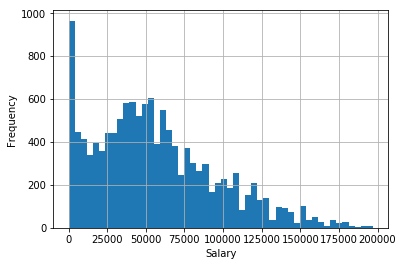

In [17]:
#I will devide the company size based on Salary as it's the column that has the highest number of missing data
#there are a lot of missing data for the salary column which is totally understandable as some participants are not employed
#and salary is also a sensitive information that not everyone is willing to share
#to answer the second question, I will take a subset of the data where missing values of salary are removed
salary_clean = survey_results[~(pd.isnull(survey_results['Salary']))]
#show a histogram of the salary column
plt.hist(salary_clean['Salary'], bins=50)
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [18]:
# we have 0 as a value here which maybe due to the vlounteering work or maybe to the fact that not eveyone would 
# necessarily provide the true information, I will print the number of participants who reported that they
# recieve less than 50 annually
print('number of low values in Salary column: {}'.format( survey_results[survey_results['Salary'] < 50].shape[0] ))


number of low values in Salary column: 51


,CompanySize,count,percentage
0,20 to 99 employees,3065,23.796584
1,100 to 499 employees,2610,20.263975
2,"10,000 or more employees",1823,14.153727
3,10 to 19 employees,1337,10.380435
4,"1,000 to 4,999 employees",1288,10.000000
5,Fewer than 10 employees,1184,9.192547
6,500 to 999 employees,851,6.607143
7,"5,000 to 9,999 employees",520,4.037267
8,I don't know,161,1.250000
9,I prefer not to answer,41,0.318323


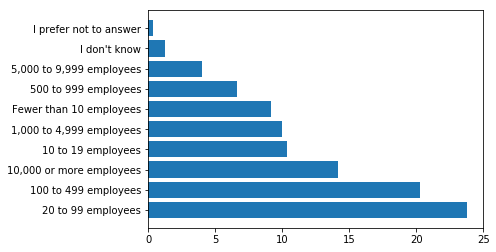

In [19]:
#I decided not to remove the low salary values as they might indicate something and they are not a lot anyways.
# After removing a big amount of data, it's good review the histogram of company size again
feature_stat_single('CompanySize', salary_clean);

In [20]:
# Now, I will devide the companies into 3 categories based on the company size and availability of data as follows: 
# small companies: [1, 99]
# medium companies: [100, 999]
# big companies: [999 or more]
# for salary & career/job satisfaction    
big_company_salary =salary_clean[salary_clean['CompanySize'].isin(['1,000 to 4,999 employees', '5,000 to 9,999 employees', '10,000 or more employees'])]
big_company_salary_mean = round(big_company_salary['Salary'].mean(),2)
medium_company_salary =salary_clean[salary_clean['CompanySize'].isin(['100 to 499 employees', '500 to 999 employees'])]
medium_company_salary_mean = round(medium_company_salary['Salary'].mean(),2)
small_company_salary =salary_clean[salary_clean['CompanySize'].isin(['Fewer than 10 employees', '10 to 19 employees', '20 to 99 employees'])]
small_company_salary_mean = round(small_company_salary['Salary'].mean(),2)

In [21]:
# I will use the same above categories for job/career satisfaction after missing data removal
careerSatisfaction_clean = survey_results[~(pd.isnull(survey_results['CareerSatisfaction']))]
big_company_careerSat =careerSatisfaction_clean[careerSatisfaction_clean['CompanySize'].isin(['1,000 to 4,999 employees', '5,000 to 9,999 employees', '10,000 or more employees'])]
big_company_careerSat_mean = round(big_company_careerSat['CareerSatisfaction'].mean(),2)
medium_company_careerSat =careerSatisfaction_clean[careerSatisfaction_clean['CompanySize'].isin(['100 to 499 employees', '500 to 999 employees'])]
medium_company_careerSat_mean = round(medium_company_careerSat['CareerSatisfaction'].mean(),2)
small_company_careerSat =careerSatisfaction_clean[careerSatisfaction_clean['CompanySize'].isin(['Fewer than 10 employees', '10 to 19 employees', '20 to 99 employees'])]
small_company_careerSat_mean = round(small_company_careerSat['CareerSatisfaction'].mean(),2)

In [22]:
jobSatisfaction_clean = survey_results[~(pd.isnull(survey_results['JobSatisfaction']))]
big_company_jobSat =jobSatisfaction_clean[jobSatisfaction_clean['CompanySize'].isin(['1,000 to 4,999 employees', '5,000 to 9,999 employees', '10,000 or more employees'])]
big_company_jobSat_mean = round(big_company_jobSat['JobSatisfaction'].mean(),2)
medium_company_jobSat =jobSatisfaction_clean[jobSatisfaction_clean['CompanySize'].isin(['100 to 499 employees', '500 to 999 employees'])]
medium_company_jobSat_mean = round(medium_company_jobSat['JobSatisfaction'].mean(),2)
small_company_jobSat =jobSatisfaction_clean[jobSatisfaction_clean['CompanySize'].isin(['Fewer than 10 employees', '10 to 19 employees', '20 to 99 employees'])]
small_company_jobSat_mean = round(small_company_jobSat['JobSatisfaction'].mean(),2)

In [23]:
comparison = np.array([['','Salary','Job Satisfaction', 'Career Satisfaction'],
                ['Small Companies',small_company_salary_mean,small_company_jobSat_mean, small_company_careerSat_mean],
                ['Medium Companies',medium_company_salary_mean,medium_company_jobSat_mean,medium_company_careerSat_mean],
                      ['Big Companies',big_company_salary_mean,big_company_jobSat_mean,big_company_careerSat_mean]])
                
comparison_df = pd.DataFrame(data=comparison[1:,1:],index=comparison[1:,0],columns=comparison[0,1:])

print(comparison_df)

                    Salary Job Satisfaction Career Satisfaction
Small Companies   47675.31             6.98                7.33
Medium Companies  57665.93             6.92                7.39
Big Companies     68496.75             6.83                7.37


- from the comparison above, we can see that almost all company types' employees have similar average value of career satisfaction. On the other hand, Big companies' employees are almost 0.1 les statisfied in their job compared to the other 2 categories that might be due to what it is said by rumors. 
- There is a clear difference in salaries between big, medium and small companies where big companies pay the highest average salary to their employees which proves the security people talk about.

### Q3: What are the strongest motivations behind people leaving their coding job?

In [24]:
#There are some questions the participants were asked when they answered that they used to work beofre 
#as a programmer but they no longer do. I will print out all the questions below
print('You said before that you used to code as part of your job, but no longer do. To what extent do you agree or disagree with the following statements?')
leaving_coding_job_cols = np.array(['ExCoderReturn', 'ExCoderNotForMe', 'ExCoderBalance', 'ExCoder10Years', 'ExCoderBelonged', 'ExCoderSkills','ExCoderWillNotCode', 'ExCoderActive'])
for col in leaving_coding_job_cols:
    print('- '+feat_info[feat_info.Column == col]['Question'].values[0][147:])

You said before that you used to code as part of your job, but no longer do. To what extent do you agree or disagree with the following statements?
-  If money weren't an issue, I would take a coding job again
-  Working as a developer just wasn't for me
-  I have better work-life balance now than I did as a developer
-  My career is going the way I thought it would 10 years ago
-  When I was a developer, I didn't feel like I belonged with my colleagues
-  I don't think my coding skills are up to date
-  I probably won't code for a living ever again
-  I'm still active in the developer community


number of missing values in ExCoderReturn column: 50469


,ExCoderReturn,count,percentage
0,Agree,250,27.085590
1,Somewhat agree,215,23.293608
2,Disagree,210,22.751896
3,Strongly agree,146,15.817985
4,Strongly disagree,102,11.050921


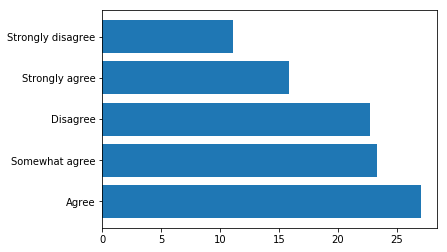

In [25]:
#since only the people whe left a developer job would get those questions, we will definitely find missing values
#I'll print now the values distribution of one of those questions
print('number of missing values in ExCoderReturn column: {}'.format(survey_results['ExCoderReturn'].isna().sum()))
feature_stat_single('ExCoderReturn', survey_results);

In [26]:
#these columns are categorical in type and they have a huge number of missing values so they need to be cleaned and encoded 
encoding = {'Strongly disagree': 1, 'Disagree': 2, 'Somewhat agree': 3,'Agree': 4, 'Strongly agree': 5}
leaving_reasons_clean = survey_results.copy()
for col in leaving_coding_job_cols:
    leaving_reasons_clean = leaving_reasons_clean[~(pd.isnull(leaving_reasons_clean[col]))]
    leaving_reasons_clean = leaving_reasons_clean.replace({col:encoding})

In [27]:
leaving_reasons_means = dict(zip(leaving_coding_job_cols, np.random.randint(1, size=8)))

In [28]:
for col in leaving_coding_job_cols:
    leaving_reasons_means[col] = round(leaving_reasons_clean[col].mean(),2)

In [29]:
leaving_reasons_means


{'ExCoderReturn': 3.14,
 'ExCoderNotForMe': 2.05,
 'ExCoderBalance': 2.88,
 'ExCoder10Years': 2.67,
 'ExCoderBelonged': 2.23,
 'ExCoderSkills': 2.97,
 'ExCoderWillNotCode': 2.47,
 'ExCoderActive': 3.2}

853 responses showed that: 
most of the developers who left their coding jobs they agree on the following statements:
- If money weren't an issue, I would take a coding job again
- I don't think my coding skills are up to date
- I'm still active in the developer community
- My career is going the way I thought it would 10 years ago
- I have better work-life balance now than I did as a developer

and disagree on:
- Working as a developer just wasn't for me
- When I was a developer, I didn't feel like I belonged with my colleagues

in the middle:
- I probably won't code for a living ever again

It seems like those who left coding jobs enjoy coding and they still do it but they don't believe it's good for a living as it doesn't pay enough.
